<a href="https://colab.research.google.com/github/Orley74/ML_projects_python/blob/main/SSD_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
feature_description = {
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
}


def _parse_function(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)
    labels = tf.sparse.to_dense(parsed_features['image/object/class/label'])

    ymin = tf.sparse.to_dense(parsed_features['image/object/bbox/ymin'])
    xmin = tf.sparse.to_dense(parsed_features['image/object/bbox/xmin'])
    ymax = tf.sparse.to_dense(parsed_features['image/object/bbox/ymax'])
    xmax = tf.sparse.to_dense(parsed_features['image/object/bbox/xmax'])
    bboxes = tf.stack([ymin, xmin, ymax, xmax], axis=-1)

    return image, (labels, bboxes)



In [ ]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
filepaths = ["/content/drive/MyDrive/yolov8_fast 2.v3i.tfrecord/train/pojazd-czlowiek-gi2t.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)


In [ ]:
for batch in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(batch.numpy())
  print(example)

features {
  feature {
    key: "image/width"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/object/class/text"
    value {
      bytes_list {
        value: "czlowiek"
        value: "czlowiek"
      }
    }
  }
  feature {
    key: "image/object/class/label"
    value {
      int64_list {
        value: 1
        value: 1
      }
    }
  }
  feature {
    key: "image/object/bbox/ymin"
    value {
      float_list {
        value: 0.609375
        value: 0.495312512
      }
    }
  }
  feature {
    key: "image/object/bbox/ymax"
    value {
      float_list {
        value: 0.689062476
        value: 0.590625
      }
    }
  }
  feature {
    key: "image/object/bbox/xmin"
    value {
      float_list {
        value: 0.564062476
        value: 0.4765625
      }
    }
  }
  feature {
    key: "image/object/bbox/xmax"
    value {
      float_list {
        value: 0.603125
        value: 0.5125
      }
    }
  }
  feature {
    key: "image

In [ ]:
dataset = dataset.map(_parse_function)


In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

tf.Tensor(
[[0.609375  0.5640625 0.6890625 0.603125 ]
 [0.4953125 0.4765625 0.590625  0.5125   ]], shape=(2, 4), dtype=float32)


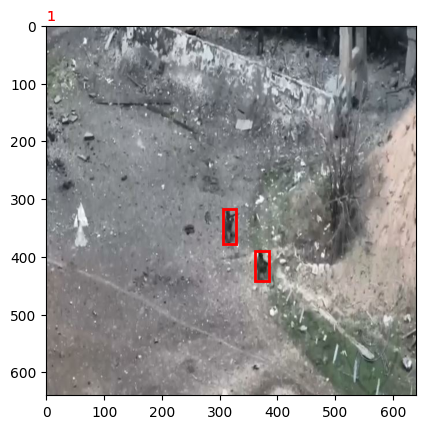

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import io

for parsed_record in dataset.take(1):
  labels = parsed_record[1][0]
  bboxs = parsed_record[1][1]
  print(parsed_record[1][1])
  fig, ax = plt.subplots(1)
  for bbox, label in zip(bboxs, labels):
    ymin = bbox[0]
    xmin = bbox[1]
    ymax = bbox[2]
    xmax = bbox[3]
    rect = patches.Rectangle((xmin * 640, ymin * 640), (xmax - xmin) * 640, (ymax - ymin) * 640, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin * 1, (ymin * 1) - 10, f'{label}', color='red', fontsize=10)

  ax.imshow(parsed_record[0])
  plt.show()

In [ ]:

batch_size = 1
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
dataset = dataset.batch(batch_size)
dataset = dataset.map(lambda X, y: (preprocess(X), y))


In [ ]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None)))>

In [ ]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras.Function.loss.


%matplotlib inline

ModuleNotFoundError: No module named 'models'

In [ ]:
tf.random.set_seed(42)  # dodatkowy kod – gwarantuje odtwarzalność
base_model = tf.keras.applications.xception.Xception(weights="imagenet",

include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(2, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                    outputs=[class_output, [loc_output]])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

model.compile(loss=["mse", "mse"],
              loss_weights=[0.8, 0.2], # zależy, co chcesz uzyskać
              optimizer=optimizer, metrics=["accuracy","mse"])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
a = model.fit(dataset, epochs=2)

Epoch 1/2


In [ ]:
a

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version